# Project 2 (mid-bootcamp) - Classification

## 1. Import librariies

In [114]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

password = getpass.getpass()

········


## 2. Load data

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)
query = '''
        select * from creditcardmarketing;
        '''

data = pd.read_sql_query(query, engine)
data

,CustomerNumber,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865


## 3. Dealing with the data & data cleaning

In [3]:
data.shape

(17976, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerNumber        17976 non-null  int64  
 1   Offer Accepted        17976 non-null  object 
 2   Reward                17976 non-null  object 
 3   Mailer Type           17976 non-null  object 
 4   Income Level          17976 non-null  object 
 5   # Bank Accounts Open  17976 non-null  int64  
 6   Overdraft Protection  17976 non-null  object 
 7   Credit Rating         17976 non-null  object 
 8   # Credit Cards Held   17976 non-null  int64  
 9   # Homes Owned         17976 non-null  int64  
 10  Household Size        17976 non-null  int64  
 11  Own Your Home         17976 non-null  object 
 12  Average Balance       17976 non-null  float64
 13  Q1 Balance            17976 non-null  int64  
 14  Q2 Balance            17976 non-null  int64  
 15  Q3 Balance         

In [5]:
data.describe()

,CustomerNumber,# Bank Accounts Open,# Credit Cards Held,# Homes Owned,Household Size,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,8999.727192,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600
std,5196.958865,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599
min,1.000000,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000
25%,4498.750000,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000
50%,9000.500000,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000
75%,13501.250000,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000
max,18000.000000,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000


In [6]:
data = data.drop_duplicates()

In [7]:
def renaming (df):
    df.columns = df.columns.str.lower()
    cols = []
    for i in range(len(df.columns)):
        cols.append(df.columns[i].lower().replace(' ', '_'))
    df.columns = cols
    print(df.columns)

In [8]:
renaming(data)

Index(['customernumber', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', '#_bank_accounts_open', 'overdraft_protection',
       'credit_rating', '#_credit_cards_held', '#_homes_owned',
       'household_size', 'own_your_home', 'average_balance', 'q1_balance',
       'q2_balance', 'q3_balance'],
      dtype='object')


In [9]:
# customernumer can act like an index because every customer number only apears one time
data=data.set_index('customernumber')

In [10]:
# Q1, Q2, Q3 can be droped because there is also the average_balance
data = data.drop(['q1_balance', 'q2_balance', 'q3_balance'], axis=1)

In [11]:
data.head()

,offer_accepted,reward,mailer_type,income_level,#_bank_accounts_open,overdraft_protection,credit_rating,#_credit_cards_held,#_homes_owned,household_size,own_your_home,average_balance
customernumber,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00


In [12]:
data.isna().sum()
# no null values

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
#_bank_accounts_open    0
overdraft_protection    0
credit_rating           0
#_credit_cards_held     0
#_homes_owned           0
household_size          0
own_your_home           0
average_balance         0
dtype: int64

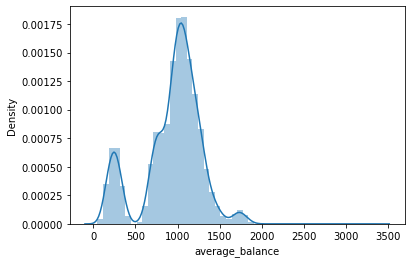

In [13]:
sns.distplot(data['average_balance'])
plt.show()

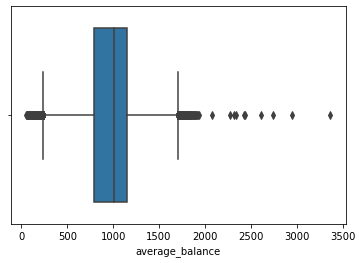

In [14]:
sns.boxplot(x=data['average_balance']) 
plt.show()

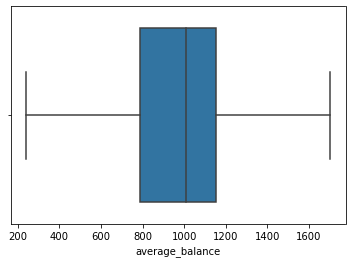

In [15]:
#removing ouliers in avg. balance
iqr = np.percentile(data['average_balance'],75) - np.percentile(data['average_balance'],25)
upper_limit = np.percentile(data['average_balance'],75) + 1.5*iqr
lower_limit = np.percentile(data['average_balance'],25) - 1.5*iqr
data.loc[data['average_balance']>upper_limit, 'average_balance']=upper_limit
data.loc[data['average_balance']<lower_limit, 'average_balance']=lower_limit

sns.boxplot(x=data['average_balance']) 
plt.show()

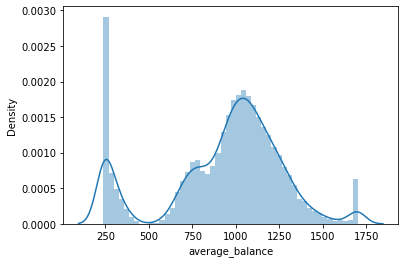

In [16]:
sns.distplot(data['average_balance'])
plt.show()

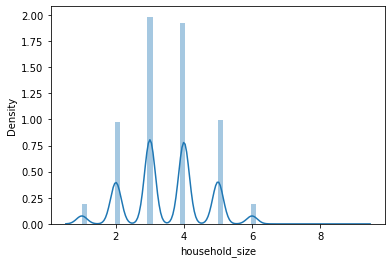

In [17]:
sns.distplot(data['household_size'])
plt.show()

In [18]:
def int_value_counts (df):
    for col in df.select_dtypes('int64'):
        print(df[col].value_counts(), '\n')

In [19]:
int_value_counts(data)

1    13674
2     4007
3      295
Name: #_bank_accounts_open, dtype: int64 

2    7933
1    6147
3    3381
4     515
Name: #_credit_cards_held, dtype: int64 

1    14502
2     3289
3      185
Name: #_homes_owned, dtype: int64 

3    5705
4    5532
5    2851
2    2809
1     539
6     538
9       1
8       1
Name: household_size, dtype: int64 



In [20]:
# only one value for houshold size 8 & 9 --> removing those rows because they are outliers and a loss of 2 rows is fine
data = data.drop(data[data.household_size>7].index)

In [21]:
data.shape

(17974, 12)

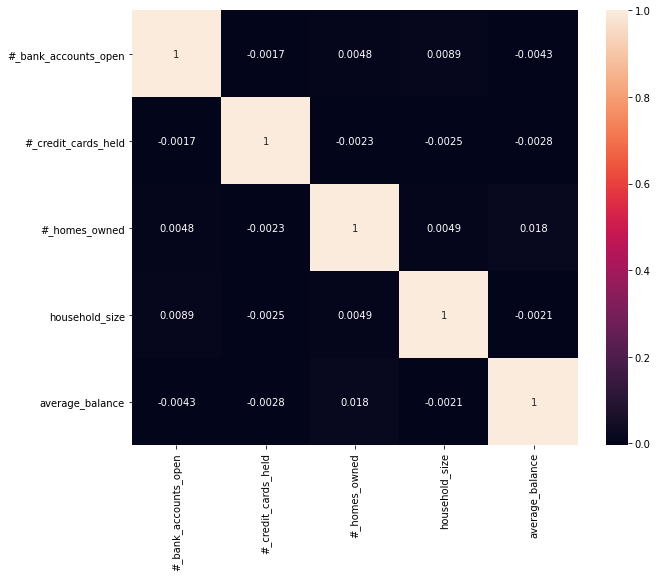

In [22]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()
# no corrolation between the numerical rows

In [23]:
def object_value_counts (df):
    for col in data.select_dtypes('object'):
        print(data[col].value_counts(), '\n')

In [24]:
object_value_counts(data)
# no strage values that have to be corrected
# offer_accepted is imbalanced

No     16954
Yes     1020
Name: offer_accepted, dtype: int64 

Air Miles    6046
Cash Back    5995
Points       5933
Name: reward, dtype: int64 

Postcard    9132
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4517
Low       4455
Name: income_level, dtype: int64 

No     15299
Yes     2675
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5946
Name: credit_rating, dtype: int64 

Yes    11636
No      6338
Name: own_your_home, dtype: int64 



## 4. Trying & Evaluating different Models

In [25]:
X = pd.get_dummies(data.drop('offer_accepted', axis=1))
y = data['offer_accepted']

In [26]:
data['offer_accepted'].value_counts()

No     16954
Yes     1020
Name: offer_accepted, dtype: int64

### 4.1 Simple LogisticRegression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [29]:
classification.score(X_test, y_test)

0.9440890125173853

In [30]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3394,    0],
       [ 201,    0]], dtype=int64)

<AxesSubplot:>

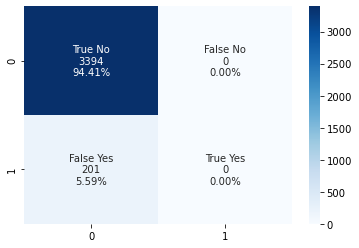

In [31]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

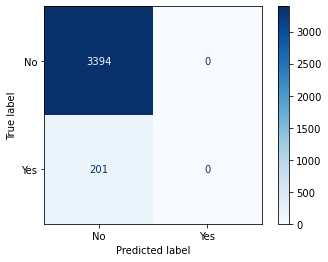

In [32]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

Good prediction of True Nos but very bad prediction of True Yes because of imbalanced data

### 4.2 LogisticRegression with class_weight='balanced'

In [33]:
classification = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
classification.fit(X_train, y_train)
classification.score(X_test, y_test)

0.6720445062586926

In [34]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[2278, 1116],
       [  63,  138]], dtype=int64)

<AxesSubplot:>

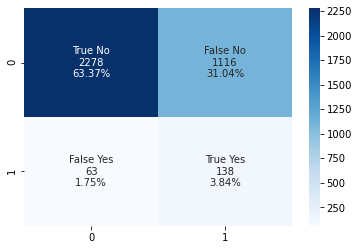

In [35]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Getting better in predicting True Yes but now there are a lot of False Nos

### 4.3 LogisticRegression with weights

In [36]:
total = sum(data['offer_accepted'].value_counts())

weights = {'No': total/(2*data['offer_accepted'].value_counts()['No']),
           'Yes': total/(2*data['offer_accepted'].value_counts()['Yes'])}
weights

{'No': 0.5300813967205379, 'Yes': 8.81078431372549}

In [37]:
classification = LogisticRegression(random_state=42, max_iter=10000, class_weight=weights)
classification.fit(X_train, y_train)
classification.score(X_test, y_test)

0.6675938803894298

In [38]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[2261, 1133],
       [  62,  139]], dtype=int64)

<AxesSubplot:>

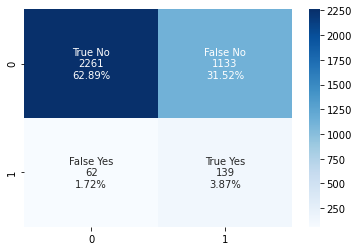

In [39]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

A little more Flase Nos

### 4.5 Different LogisticRegressions with SMOTE

In [40]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     16954
Yes    16954
Name: offer_accepted, dtype: int64

In [41]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

### LogisticRegression

In [42]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train_sm, y_train_sm)
classification.score(X_test_sm, y_test_sm)

0.9576820996756119

In [43]:
predictions = classification.predict(X_test_sm)
confusion_matrix(y_test_sm, predictions)

array([[3366,    3],
       [ 284, 3129]], dtype=int64)

<AxesSubplot:>

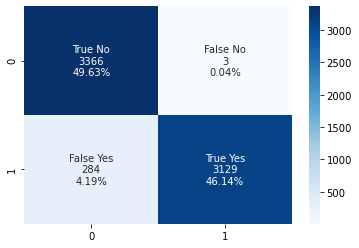

In [44]:
cf_matrix = confusion_matrix(y_test_sm, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Looks quite good but you have to be sure if it's okay the data into a balanced dataset

### LogisticRegression with class_weight='balanced'

In [45]:
classification = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
classification.fit(X_train_sm, y_train_sm)
classification.score(X_test_sm, y_test_sm)

0.9578295488056621

In [46]:
predictions = classification.predict(X_test_sm)
confusion_matrix(y_test_sm, predictions)

array([[3367,    2],
       [ 284, 3129]], dtype=int64)

<AxesSubplot:>

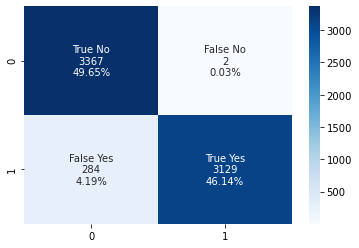

In [47]:
cf_matrix = confusion_matrix(y_test_sm, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Very simmilar to the above one, of course, because the SMOTE data is already balanced

### LogisticRegression with weights

In [48]:
classification = LogisticRegression(random_state=42, max_iter=10000, class_weight=weights)
classification.fit(X_train_sm, y_train_sm)
classification.score(X_test_sm, y_test_sm)

0.8033028605131229

In [49]:
predictions = classification.predict(X_test_sm)
confusion_matrix(y_test_sm, predictions)

array([[2100, 1269],
       [  65, 3348]], dtype=int64)

<AxesSubplot:>

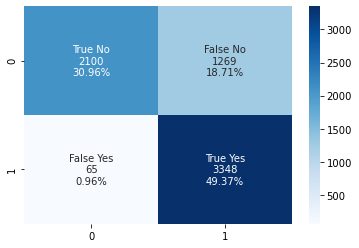

In [50]:
cf_matrix = confusion_matrix(y_test_sm, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The True Yes rate is good but now the False Nos are quie high

### 4.6 KNN 

In [97]:
def using_KNNClassifier (y,X,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classification = KNeighborsClassifier(n_neighbors=n)
    classification.fit(X_train, y_train)
    predictions = classification.predict(X_test)
    score = classification.score(X_test, y_test)
    print(score)
    
    predictions = classification.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    
    cf_matrix = confusion_matrix(y_test, predictions)
    group_names = ['True No', 'False No',
                   'False Yes', 'True Yes',]

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.9418636995827538
[[3384   10]
 [ 199    2]]


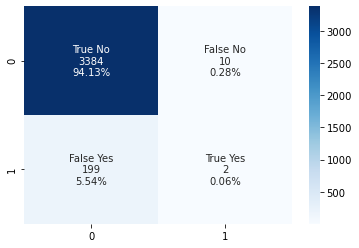

In [103]:
using_KNNClassifier(y,X,2)

0.9438108484005563
[[3393    1]
 [ 201    0]]


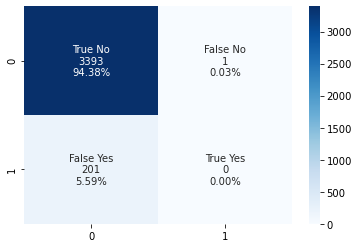

In [102]:
using_KNNClassifier(y,X,4)

0.9440890125173853
[[3394    0]
 [ 201    0]]


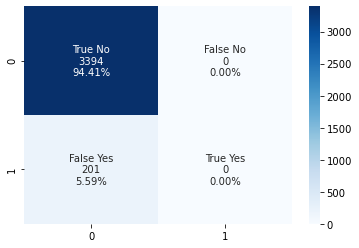

In [100]:
using_KNNClassifier(y,X,15)

0.9440890125173853
[[3394    0]
 [ 201    0]]


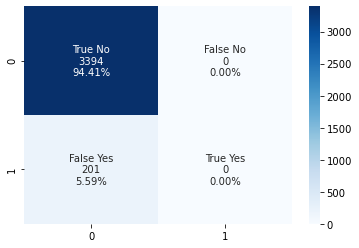

In [98]:
using_KNNClassifier(y,X,50)

0.9440890125173853
[[3394    0]
 [ 201    0]]


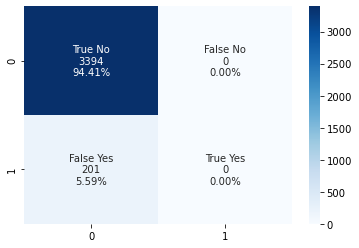

In [99]:
using_KNNClassifier(y,X,100)

The KKNCLassifier seems not to be the best option even with different n_neighbors

### With SMOTE data

0.9393984075493954
[[3055  314]
 [  97 3316]]


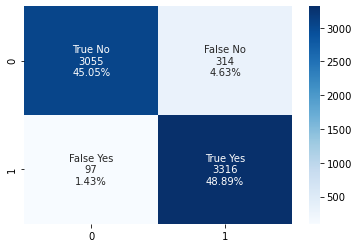

In [108]:
using_KNNClassifier(y_sm,X_sm,2)

0.9087289884989679
[[2797  572]
 [  47 3366]]


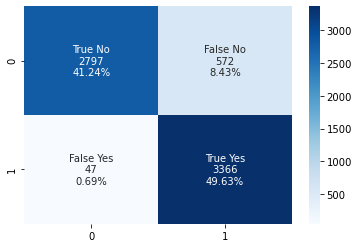

In [104]:
using_KNNClassifier(y_sm,X_sm,4)

0.808905927455028
[[2115 1254]
 [  42 3371]]


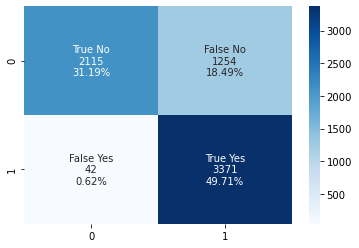

In [107]:
using_KNNClassifier(y_sm,X_sm,15)

0.7375405485107638
[[1776 1593]
 [ 187 3226]]


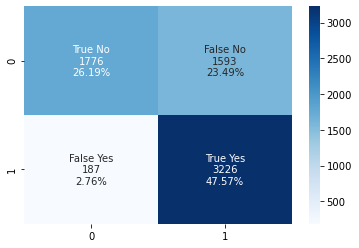

In [106]:
using_KNNClassifier(y_sm,X_sm,50)

KNN with a low n_neighbors seems to be an option

### 4.7 DesisionTreeClassifier

In [115]:
def using_DecisionTreeClassifier (y,X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classification = DecisionTreeClassifier()
    classification.fit(X_train, y_train)
    predictions = classification.predict(X_test)
    score = classification.score(X_test, y_test)
    print(score)
    
    predictions = classification.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    
    cf_matrix = confusion_matrix(y_test, predictions)
    group_names = ['True No', 'False No',
                   'False Yes', 'True Yes',]

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.886230876216968
[[3164  230]
 [ 179   22]]


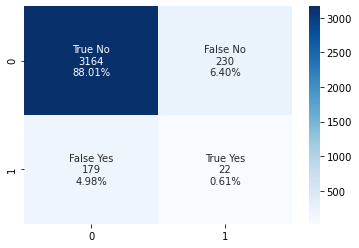

In [116]:
using_DecisionTreeClassifier (y,X)

Yes mostly isn't predicted right

In [117]:
def using_DecisionTreeClassifier_with_class_weights (y,X,w):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classification = DecisionTreeClassifier(class_weight=w)
    classification.fit(X_train, y_train)
    predictions = classification.predict(X_test)
    score = classification.score(X_test, y_test)
    print(score)
    
    predictions = classification.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    
    cf_matrix = confusion_matrix(y_test, predictions)
    group_names = ['True No', 'False No',
                   'False Yes', 'True Yes',]

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.9006954102920723
[[3217  177]
 [ 180   21]]


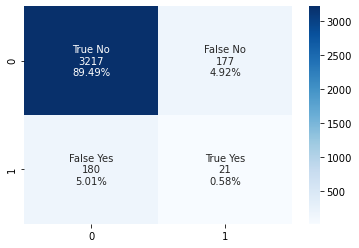

In [118]:
using_DecisionTreeClassifier_with_class_weights (y,X,weights)

0.9015299026425591
[[3222  172]
 [ 182   19]]


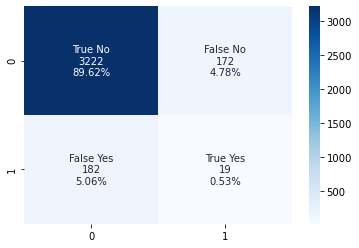

In [119]:
b = 'balanced'
using_DecisionTreeClassifier_with_class_weights (y,X,b)

Using class weights or 'balanced' doesn't help much